In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    balanced_accuracy_score, classification_report, confusion_matrix,
    precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("agri_CO2_preprocessing_ex.csv")
print(df.columns)

Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission',
       'Average Temperature °C'],
      dtype='object')


In [3]:
emission_cols = [
    'Savanna fires', 'Forest fires', 'Crop Residues', 'Rice Cultivation',
    'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport',
    'Forestland', 'Net Forest conversion', 'Food Household Consumption',
    'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
    'Agrifood Systems Waste Disposal', 'Food Processing', 'Fertilizers Manufacturing',
    'IPPU', 'Manure applied to Soils', 'Manure left on Pasture', 'Manure Management',
    'Fires in organic soils', 'Fires in humid tropical forests',
    'On-farm energy use'
]

In [4]:
# Dictionary of global annual temperature change
yearly_avg_temp = {
    1990: 0.18, 1991: -0.04, 1992: -0.19, 1993: 0.01, 1994: 0.08, 
    1995: 0.13, 1996: -0.11, 1997: 0.13, 1998: 0.15, 1999: -0.23, 
    2000: 0.01, 2001: 0.14, 2002: 0.10, 2003: -0.01, 2004: -0.09, 
    2005: 0.15, 2006: -0.04, 2007: 0.02, 2008: -0.12, 2009: 0.12, 
    2010: 0.07, 2011: -0.12, 2012: 0.04, 2013: 0.03, 2014: 0.07, 
    2015: 0.15, 2016: 0.11, 2017: -0.09, 2018: -0.07, 2019: 0.13, 
    2020: 0.03

}

# Map the temperature to the dataframe by Year
df['Yearly_Avg_Temp'] = df['Year'].map(yearly_avg_temp)

In [5]:
df['Detrended_Temp'] = df['Average Temperature °C'] - df['Yearly_Avg_Temp']
df['temp_label'] = np.where(df['Detrended_Temp'] >= 0, 1, 0)
print("Label occurences:\n", df["temp_label"].value_counts())

Label occurences:
 temp_label
1    6624
0     310
Name: count, dtype: int64


In [6]:
# 建立更新後的洲別分類對應（針對該資料實際出現的國家名稱）
continent_mapping_updated = {
    'Africa': [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon',
        'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Côte d\'Ivoire', 'Djibouti', 'Egypt',
        'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea',
        'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali',
        'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
        'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
        'South Sudan', 'Sudan', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
    ],
    'Asia': [
        'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei Darussalam',
        'Cambodia', 'China', 'China, mainland', 'China, Hong Kong SAR', 'China, Macao SAR',
        'China, Taiwan Province of', 'Cyprus', 'Georgia', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel',
        'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives',
        'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 'Oman', 'Pakistan', 'Palestine', 'Philippines',
        'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Tajikistan', 'Thailand',
        'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'
    ],
    'Europe': [
        'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Bosnia and Herzegovina',
        'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania',
        'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia',
        'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain',
        'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'
    ],
    'North America': [
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica', 'Cuba',
        'Dominica', 'Dominican Republic', 'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
        'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts and Nevis', 'Saint Lucia',
        'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States'
    ],
    'Oceania': [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand',
        'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'
    ],
    'South America': [
        'Argentina', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
        'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    ]
}

# 將國家指派到對應洲別
def assign_continent(country):
    for continent, countries in continent_mapping_updated.items():
        if country in countries:
            return continent
    return "Other"  # 若無匹配則標為 Other

# 套用洲別分類
df['continent'] = df['Area'].apply(assign_continent)

# 檢查每個洲包含幾筆資料
# continent_counts = df['continent'].value_counts()
# continent_counts

manual_country_to_continent = {
    # North America / Caribbean
    'American Samoa': 'Oceania',
    'Anguilla': 'North America',
    'Aruba': 'North America',
    'Bermuda': 'North America',
    'British Virgin Islands': 'North America',
    'Cayman Islands': 'North America',
    'Cook Islands': 'Oceania',
    'Falkland Islands (Malvinas)': 'South America',
    'French Polynesia': 'Oceania',
    'Greenland': 'North America',
    'Guadeloupe': 'North America',
    'Guam': 'Oceania',
    'Martinique': 'North America',
    'Mayotte': 'Africa',
    'Montserrat': 'North America',
    'Netherlands Antilles (former)': 'North America',
    'New Caledonia': 'Oceania',
    'Niue': 'Oceania',
    'Northern Mariana Islands': 'Oceania',
    'Pacific Islands Trust Territory': 'Oceania',
    'Puerto Rico': 'North America',
    'Saint Pierre and Miquelon': 'North America',
    'Saint Helena, Ascension and Tristan da Cunha': 'Africa',
    'Tokelau': 'Oceania',
    'Turks and Caicos Islands': 'North America',
    'United States Virgin Islands': 'North America',
    'Wallis and Futuna Islands': 'Oceania',
    'Western Sahara': 'Africa',

    # Europe
    'Faroe Islands': 'Europe',
    'Gibraltar': 'Europe',
    'Holy See': 'Europe',
    'Isle of Man': 'Europe',
    'Netherlands (Kingdom of the)': 'Europe',

    # Asia
    'Democratic People\'s Republic of Korea': 'Asia',
    'Iran (Islamic Republic of)': 'Asia',
    'Lao People\'s Democratic Republic': 'Asia',
    'Republic of Korea': 'Asia',
    'Syrian Arab Republic': 'Asia',
    'Venezuela (Bolivarian Republic of)': 'South America',
    'Viet Nam': 'Asia',

    # Europe (historic or alt names)
    'Czechia': 'Europe',
    'Czechoslovakia': 'Europe',
    'Republic of Moldova': 'Europe',
    'Russian Federation': 'Europe',
    'Serbia and Montenegro': 'Europe',
    'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'Yugoslav SFR': 'Europe',

    # Africa
    'Ethiopia PDR': 'Africa',
    'United Republic of Tanzania': 'Africa',
    'Sudan (former)': 'Africa',

    # Other (defunct)
    'USSR': 'Europe',
    'United States of America': 'North America',
}

# 更新 assign_continent 函數
def assign_continent_updated(country):
    # 先檢查補充表
    if country in manual_country_to_continent:
        return manual_country_to_continent[country]
    # 再檢查原始洲別表
    for continent, countries in continent_mapping_updated.items():
        if country in countries:
            return continent
    return "Other"

# 套用更新後的洲別分類
df["continent"] = df["Area"].apply(assign_continent_updated)

# 檢查結果
df["continent"].value_counts()

continent
Africa           1680
Asia             1565
Europe           1408
North America    1137
Oceania           680
South America     403
Other              61
Name: count, dtype: int64

In [7]:
# 1. Drop near-constant columns
vt = VarianceThreshold(threshold=0.01)  # tune threshold
reduced_df = df[emission_cols]
filtered = vt.fit_transform(reduced_df)

# Get column names that survived
selected_cols = [col for col, keep in zip(reduced_df.columns, vt.get_support()) if keep]
# None dropped

In [10]:
# Step 1: Correlation matrix (absolute values)
corr_matrix = df[selected_cols].corr().abs()

# Step 2: Upper triangle mask (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Calculate p-values for all features
X = df[selected_cols]
y = df['Detrended_Temp']
f_vals, p_vals = f_regression(X, y)

# Create a dictionary mapping feature -> p-value
pval_dict = dict(zip(X.columns, p_vals))

# Step 4: Identify correlated pairs and drop the one with higher p-value
to_drop = set()
for col in upper_tri.columns:
    for row in upper_tri.index:
        if row != col and upper_tri.loc[row, col] > 0.9:
            p1 = pval_dict.get(row, 1.0)
            p2 = pval_dict.get(col, 1.0)
            if p1 > p2:
                to_drop.add(row)
            else:
                to_drop.add(col)

# Step 5: Filter columns
filtered_cols = [col for col in selected_cols if col not in to_drop]

print("Dropped due to correlation & p-value comparison:", to_drop)
print("Remaining features:", filtered_cols)

Dropped due to correlation & p-value comparison: {'Agrifood Systems Waste Disposal', 'Food Processing', 'Manure Management', 'Fires in humid tropical forests', 'Fertilizers Manufacturing', 'On-farm energy use', 'Crop Residues', 'Food Packaging', 'Food Household Consumption'}
Remaining features: ['Savanna fires', 'Forest fires', 'Rice Cultivation', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport', 'Forestland', 'Net Forest conversion', 'Food Retail', 'On-farm Electricity Use', 'IPPU', 'Manure applied to Soils', 'Manure left on Pasture', 'Fires in organic soils']


In [11]:
display(df.head())

,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,...,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C,Yearly_Avg_Temp,Detrended_Temp,temp_label,continent
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,9655167,2593947,5348387.0,5346409.0,2198.963539,0.536167,0.18,0.356167,1,Asia
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,10230490,2763167,5372959.0,5372208.0,2323.876629,0.020667,-0.04,0.060667,1,Asia
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,10995568,2985663,6028494.0,6028939.0,2356.304229,-0.259583,-0.19,-0.069583,0,Asia
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,11858090,3237009,7003641.0,7000119.0,2368.470529,0.101917,0.01,0.091917,1,Asia
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,12690115,3482604,7733458.0,7722096.0,2500.768729,0.372250,0.08,0.292250,1,Asia



🌍 Processing continent: Asia


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'Continent': 'Asia', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.7717206132879046, 'Recall': 0.6109215017064846, 'Recall (class 1)': 0.6109215017064846, 'Recall (class 0)': 0.9319727891156463, 'Precision (class 1)': 0.8994974874371859, 'Precision (class 0)': 0.7061855670103093, 'F1 Score (macro)': 0.765580669003171, 'Balanced Accuracy': 0.7714471454110654}
Confusion Matrix:
[[274  20]
 [114 179]]


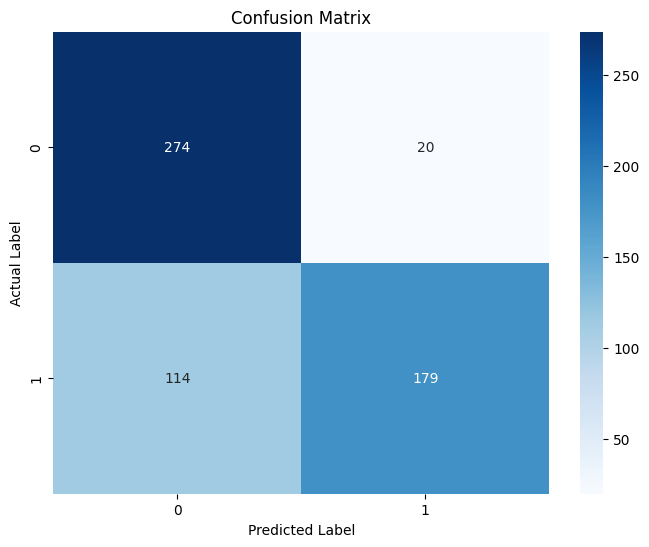

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       294
           1       0.90      0.61      0.73       293

    accuracy                           0.77       587
   macro avg       0.80      0.77      0.77       587
weighted avg       0.80      0.77      0.77       587


🌍 Processing continent: Europe


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
{'Continent': 'Europe', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.774859287054409, 'Recall': 0.6766917293233082, 'Recall (class 1)': 0.6766917293233082, 'Recall (class 0)': 0.8726591760299626, 'Precision (class 1)': 0.8411214953271028, 'Precision (class 0)': 0.7304075235109718, 'F1 Score (macro)': 0.7726109215017065, 'Balanced Accuracy': 0.7746754526766354}
Confusion Matrix:
[[233  34]
 [ 86 180]]


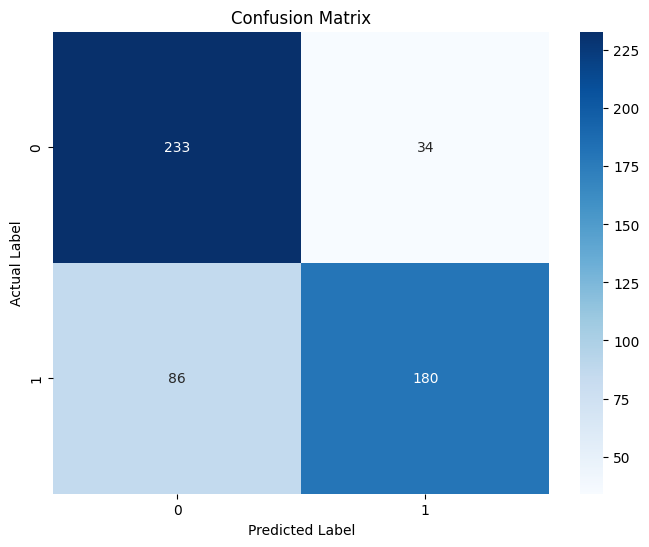

              precision    recall  f1-score   support

           0       0.73      0.87      0.80       267
           1       0.84      0.68      0.75       266

    accuracy                           0.77       533
   macro avg       0.79      0.77      0.77       533
weighted avg       0.79      0.77      0.77       533


🌍 Processing continent: Africa


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
{'Continent': 'Africa', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.9247311827956989, 'Recall': 0.9046153846153846, 'Recall (class 1)': 0.9046153846153846, 'Recall (class 0)': 0.9447852760736196, 'Precision (class 1)': 0.9423076923076923, 'Precision (class 0)': 0.9085545722713865, 'F1 Score (macro)': 0.9246963562753037, 'Balanced Accuracy': 0.924700330344502}
Confusion Matrix:
[[308  18]
 [ 31 294]]


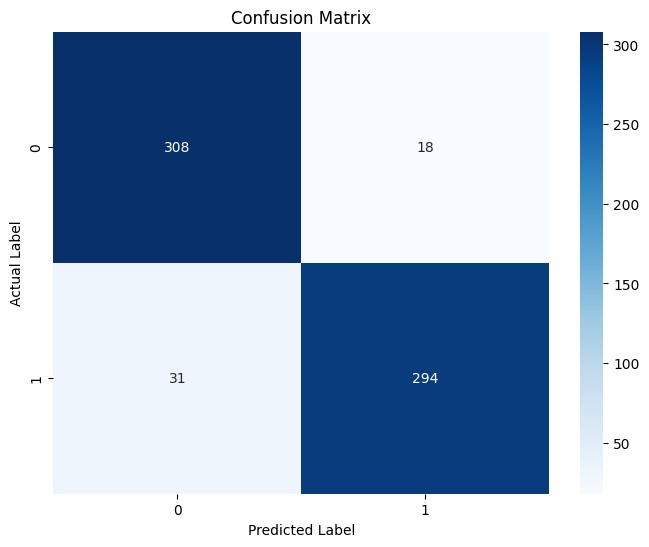

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       326
           1       0.94      0.90      0.92       325

    accuracy                           0.92       651
   macro avg       0.93      0.92      0.92       651
weighted avg       0.93      0.92      0.92       651


🌍 Processing continent: Oceania


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
{'Continent': 'Oceania', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.7276264591439688, 'Recall': 0.609375, 'Recall (class 1)': 0.609375, 'Recall (class 0)': 0.8449612403100775, 'Precision (class 1)': 0.7959183673469388, 'Precision (class 0)': 0.6855345911949685, 'F1 Score (macro)': 0.723604965585054, 'Balanced Accuracy': 0.7271681201550387}
Confusion Matrix:
[[109  20]
 [ 50  78]]


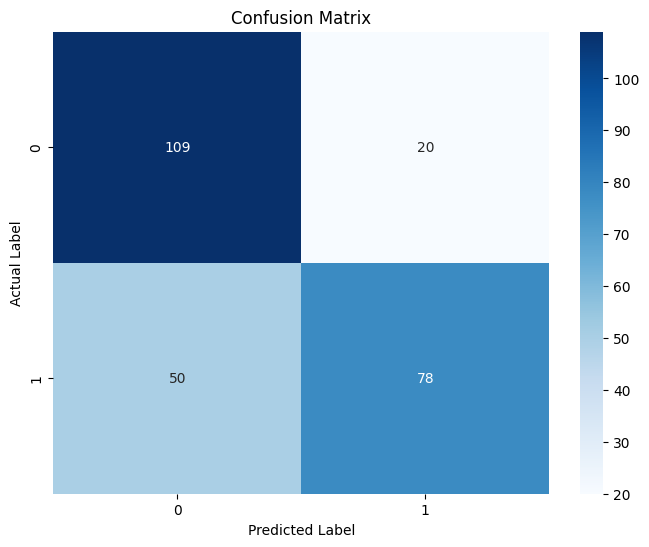

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       129
           1       0.80      0.61      0.69       128

    accuracy                           0.73       257
   macro avg       0.74      0.73      0.72       257
weighted avg       0.74      0.73      0.72       257


🌍 Processing continent: North America


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
{'Continent': 'North America', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.9665178571428571, 'Recall': 0.9464285714285714, 'Recall (class 1)': 0.9464285714285714, 'Recall (class 0)': 0.9866071428571429, 'Precision (class 1)': 0.986046511627907, 'Precision (class 0)': 0.9484978540772532, 'F1 Score (macro)': 0.9665043389840646, 'Balanced Accuracy': 0.9665178571428572}
Confusion Matrix:
[[221   3]
 [ 12 212]]


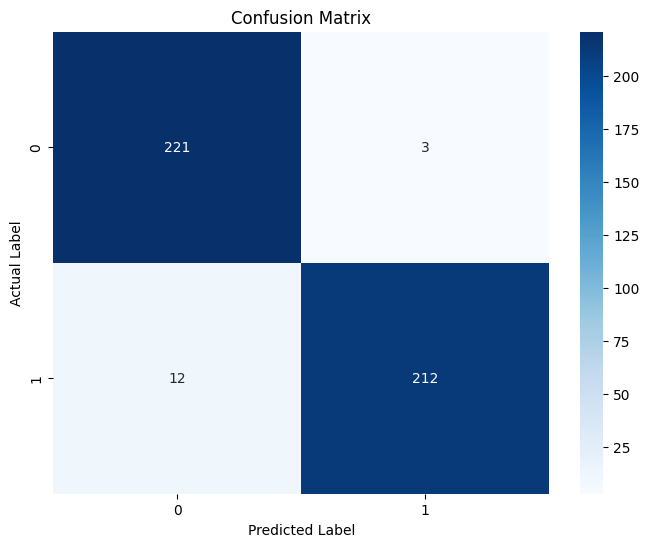

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       224
           1       0.99      0.95      0.97       224

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448


🌍 Processing continent: South America


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
{'Continent': 'South America', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.9102564102564102, 'Recall': 0.8589743589743589, 'Recall (class 1)': 0.8589743589743589, 'Recall (class 0)': 0.9615384615384616, 'Precision (class 1)': 0.9571428571428572, 'Precision (class 0)': 0.872093023255814, 'F1 Score (macro)': 0.9100197758734344, 'Balanced Accuracy': 0.9102564102564102}
Confusion Matrix:
[[75  3]
 [11 67]]


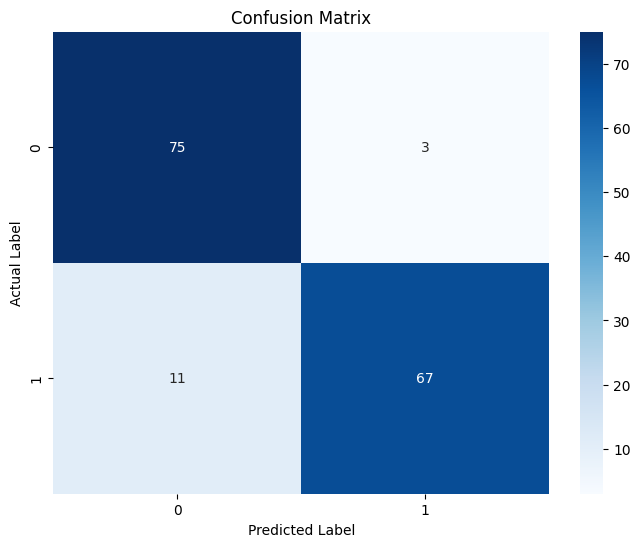

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        78
           1       0.96      0.86      0.91        78

    accuracy                           0.91       156
   macro avg       0.91      0.91      0.91       156
weighted avg       0.91      0.91      0.91       156


🌍 Processing continent: Other


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
{'Continent': 'Other', 'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.9, 'Recall': 0.9, 'Recall (class 1)': 0.9, 'Recall (class 0)': 0.9, 'Precision (class 1)': 0.9, 'Precision (class 0)': 0.9, 'F1 Score (macro)': 0.9, 'Balanced Accuracy': 0.9}
Confusion Matrix:
[[9 1]
 [1 9]]


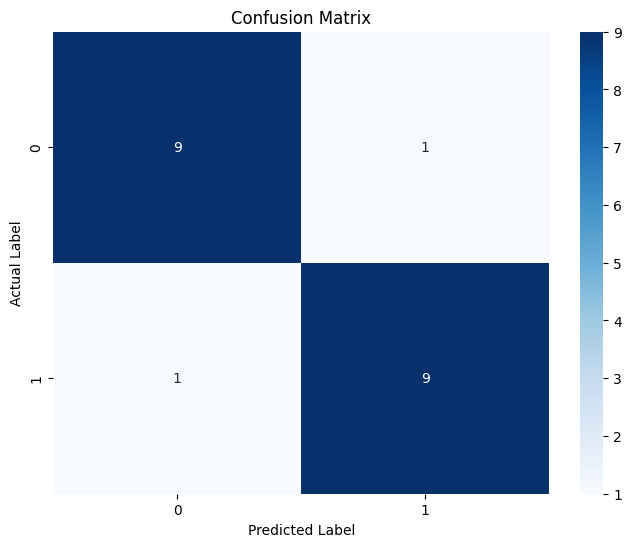

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [12]:
# X = df[filtered_cols]
#　y = df['Average Temperature °C']
continents = df['continent'].unique()
rnn_results = []

rnn_sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
}

for continent in continents:
    print(f"\n🌍 Processing continent: {continent}")
    
    # Filter by continent
    df_continent = df[df['continent'] == continent]

    # Define X and y
    X = df_continent[filtered_cols]
    y = df_continent['temp_label']

    for name, sampler in rnn_sampling_strategies.items():
        # Scale
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply sampler
        X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)

        # Reshape for RNN: (samples, timesteps, features)
        X_rnn = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

        # Split
        X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)

        # RNN Model
        rnn_model = Sequential([
            SimpleRNN(32, activation='relu', input_shape=(1, X.shape[1])),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        rnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

        # Define EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train RNN with EarlyStopping
        history = rnn_model.fit(
            X_train_rnn, y_train_rnn, 
            epochs=100, 
            batch_size=16, 
            validation_split=0.2, 
            verbose=0,
            callbacks=[early_stopping]
        )


        rnn_model.save(f"rnn_model_{continent}.h5")

        y_pred_rnn = (rnn_model.predict(X_test_rnn) > 0.5).astype(int)

        print({
            'Continent': continent,
            'Sampling': name,
            'Model': 'RNN',
            'Accuracy': accuracy_score(y_test_rnn, y_pred_rnn),
            'Recall' : recall_score(y_test_rnn, y_pred_rnn),
            'Recall (class 1)': recall_score(y_test_rnn, y_pred_rnn, pos_label=1),
            'Recall (class 0)': recall_score(y_test_rnn, y_pred_rnn, pos_label=0),
            'Precision (class 1)': precision_score(y_test_rnn, y_pred_rnn, pos_label=1),
            'Precision (class 0)': precision_score(y_test_rnn, y_pred_rnn, pos_label=0),
            'F1 Score (macro)': f1_score(y_test_rnn, y_pred_rnn, average='macro'),
            'Balanced Accuracy': balanced_accuracy_score(y_test_rnn, y_pred_rnn)
        })
        
        # Get confusion matrix
        cm = confusion_matrix(y_test_rnn, y_pred_rnn)

        # Display the confusion matrix
        print("Confusion Matrix:")
        print(cm)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        # plt.savefig("confusion.png")
        plt.show()
        print(classification_report(y_test_rnn, y_pred_rnn))
        

In [ ]:
# Get confusion matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion.png")
plt.show()

In [ ]:

print(classification_report(y_test_rnn, y_pred_rnn))